In [1]:
import torch
import torchvision
from torchvision import transforms
from PIL import Image
import pandas as pd
import numpy as np
from pathlib import Path
import os
import shutil
from zipfile import ZipFile
import matplotlib.pyplot as plt

## Data Extraction

If you don't have the `.h5` file downloaded..run this code

In [ ]:
from astroNN.datasets import load_galaxy10
import numpy as np

images, labels = load_galaxy10()

Since I already have a `.h5` file downloaded, I will run the folllowing block of code

In [9]:
import h5py
import numpy as np

h5_path = Path("/home/asus/Desktop/Galaxy_type_classification_project/Galaxy10_DECals.h5")

with h5py.File(h5_path, "r") as f:
    images = np.array(f["images"])  # (N, 256, 256, 3)
    labels = np.array(f["ans"])     # (N,)

In [10]:
print(images.shape, images.dtype)
print(labels.shape, labels.dtype)
print(np.unique(labels))

(17736, 256, 256, 3) uint8
(17736,) uint8
[0 1 2 3 4 5 6 7 8 9]


In [3]:
CLASS_NAMES = [
    "disturbed",
    "merging",
    "round_smooth",
    "in_between_round_smooth",
    "cigar_shaped",
    "barred_spiral",
    "unbarred_tight_spiral",
    "unbarred_loose_spiral",
    "edge_on_no_bulge",
    "edge_on_with_bulge"
]

In [23]:
from sklearn.model_selection import train_test_split

indices = np.arange(len(images))

train_idx, temp_idx = train_test_split(
    indices, test_size=0.2, stratify=labels, random_state=42
)

val_idx, test_idx = train_test_split(
    temp_idx,
    test_size=0.5,
    stratify=labels[temp_idx],
    random_state=42
)

In [26]:
val_idx

array([ 3800,  8056, 12292, ..., 14871,  8079,    27])

In [9]:
from pathlib import Path

base_dir = Path("../data/Galaxy10_DECaLS")

for split in ["train", "val", "test"]:
    for cls in CLASS_NAMES:
        (base_dir / split / cls).mkdir(parents=True, exist_ok=True)

In [10]:
def save_split(indices, split_name):
    for i in indices:
        cls_name = CLASS_NAMES[labels[i]]
        img = Image.fromarray(images[i])
        img_path = base_dir / split_name / cls_name / f"img_{i}.jpg"
        img.save(img_path, quality=95)

save_split(train_idx, "train")
save_split(val_idx, "val")
save_split(test_idx, "test")

In [12]:
values, counts = np.unique(labels, return_counts=True)

values,counts

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8),
 array([1081, 1853, 2645, 2027,  334, 2043, 1829, 2628, 1423, 1873]))

## Data Visualisation

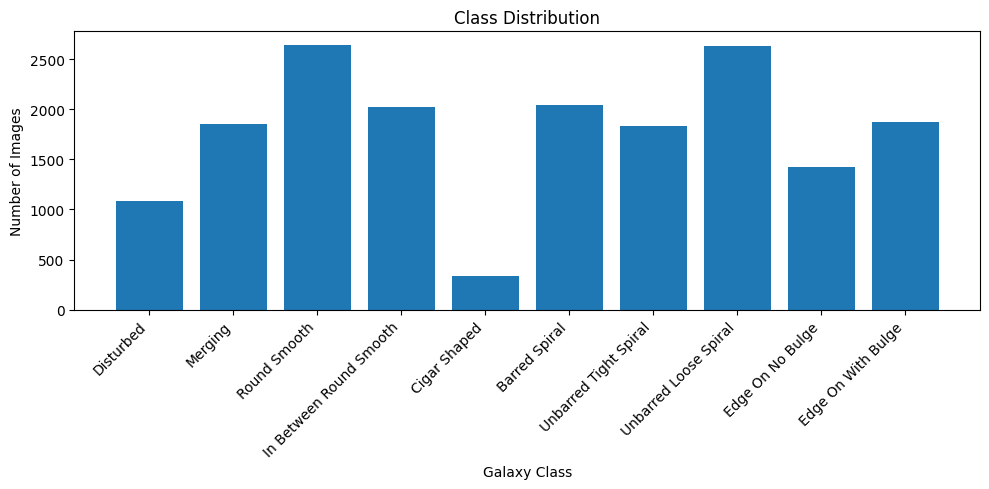

In [ ]:
plt.figure(figsize=(10, 5))
plt.bar(
    x=[' '.join(CLASS_NAMES[v].split('_')).title() for v in values],
    height=counts
)
plt.xticks(rotation=45, ha="right")
plt.xlabel("Galaxy Class")
plt.ylabel("Number of Images")
plt.title("Class Distribution")
plt.tight_layout()
plt.show()


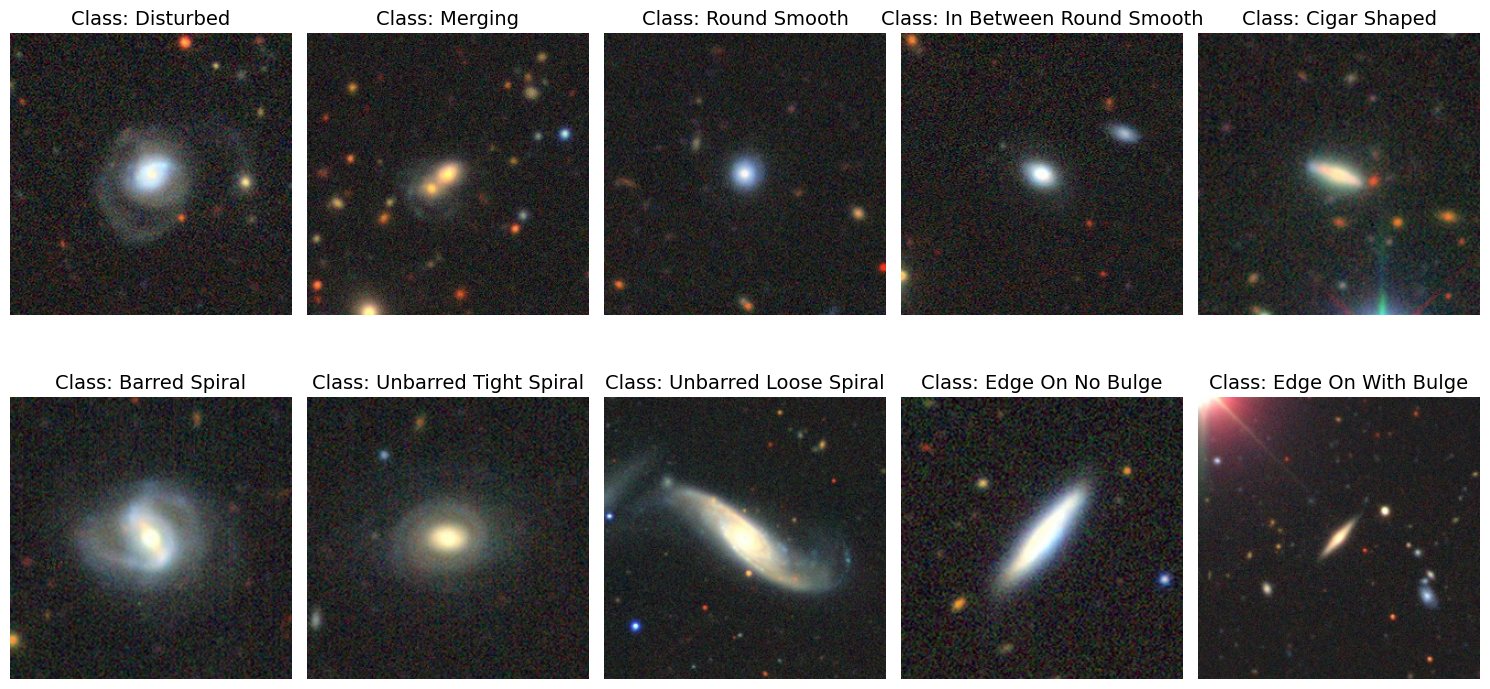

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(15, 8))
axes_flat = axes.flatten()

for i, Class in enumerate(CLASS_NAMES):
    class_path = Path(f"../data/Galaxy10_DECaLS/test/{Class}")
    img_path = next(class_path.glob("*.jpg"), None)
    
    if img_path and i < len(axes_flat):
        img = Image.open(img_path)
        axes_flat[i].imshow(img)
        axes_flat[i].set_title(f"Class: {' '.join(Class.split('_')).title()}", fontsize=14)
        axes_flat[i].axis('off') 
    else:
        print(f"No images found or ran out of subplots for {Class}")

plt.tight_layout()
plt.show()

Let's see more examples of such galaxies to form an intutive grasp of the features of these galaxy shapes

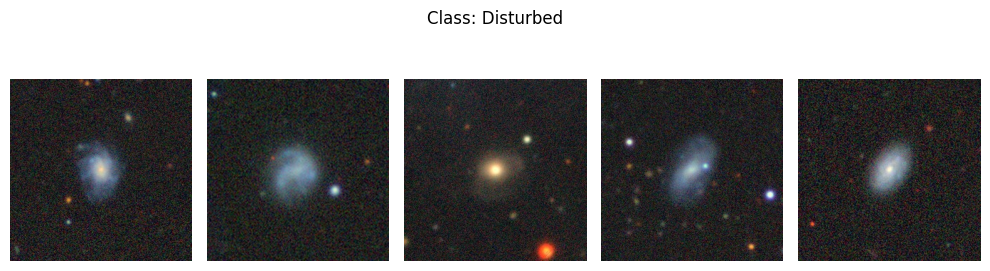

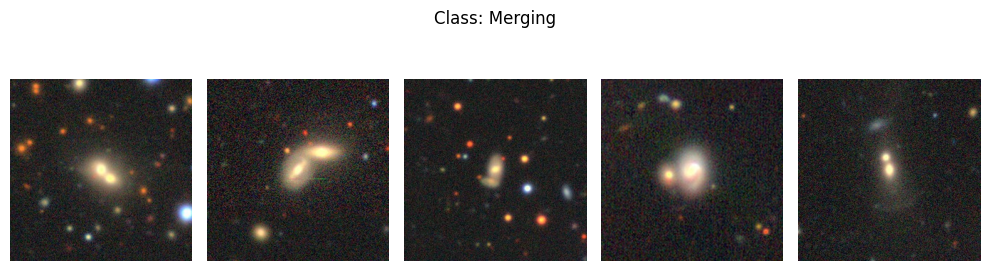

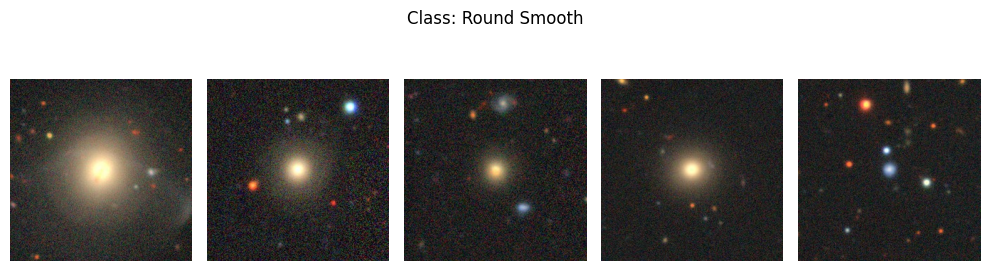

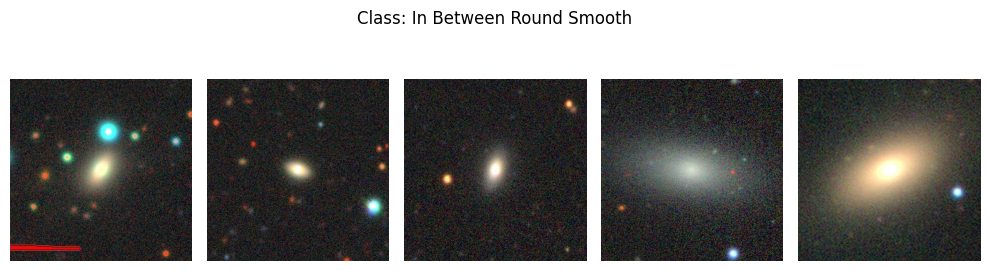

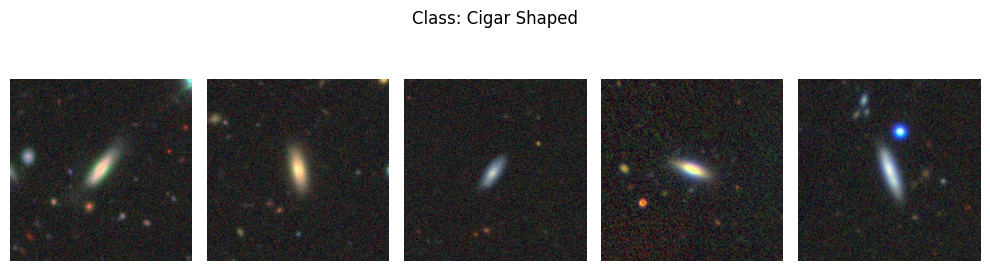

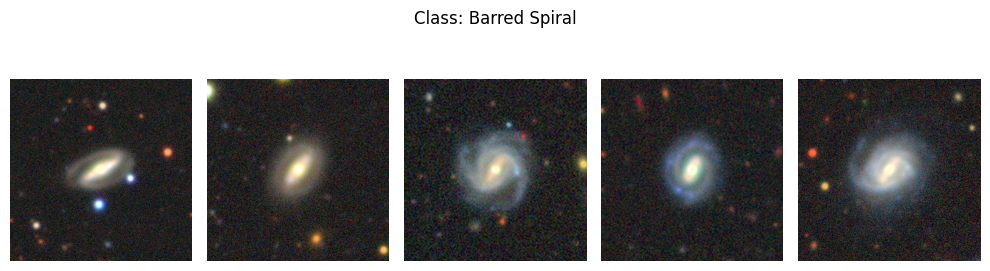

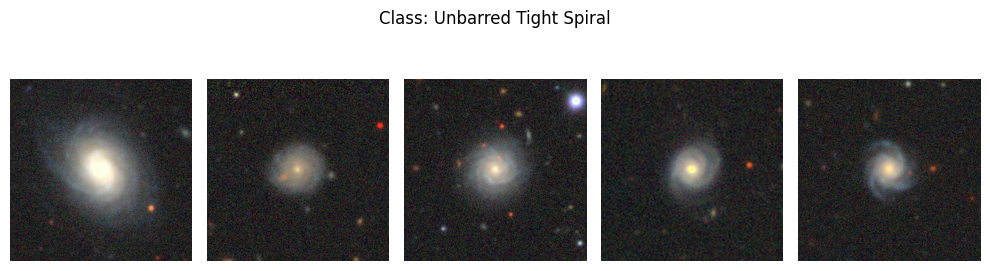

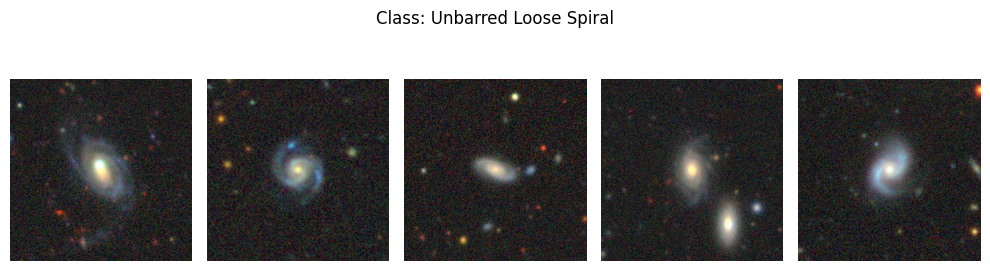

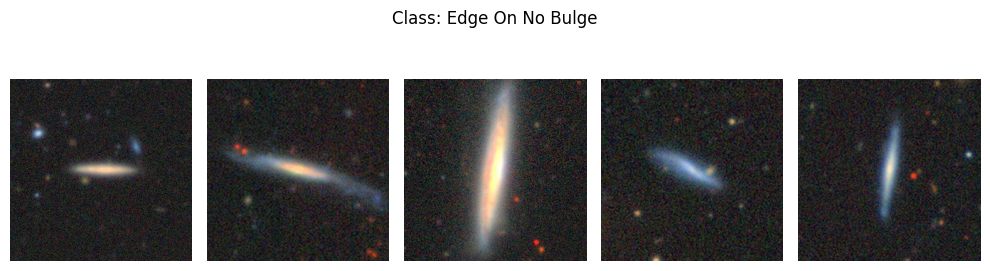

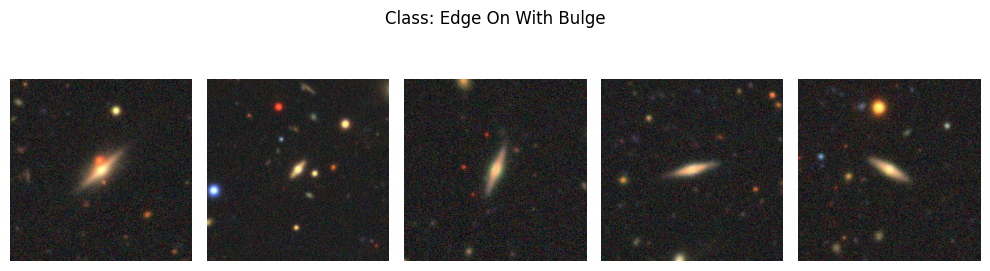

In [14]:
from src.utils.visualisations import class_visualisation

for cls_name in CLASS_NAMES:
    class_visualisation(cls_name)

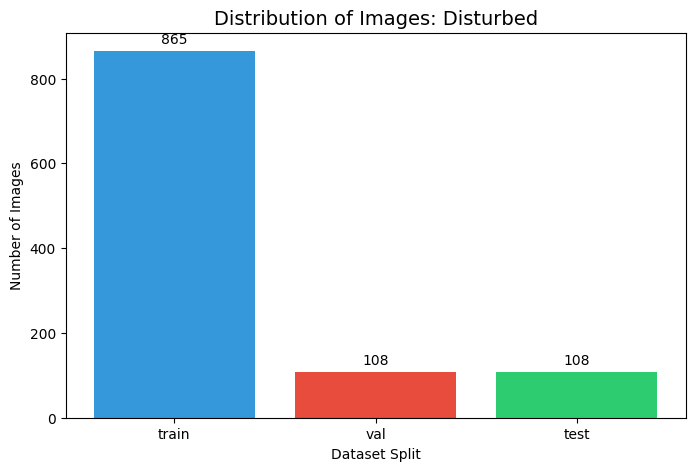

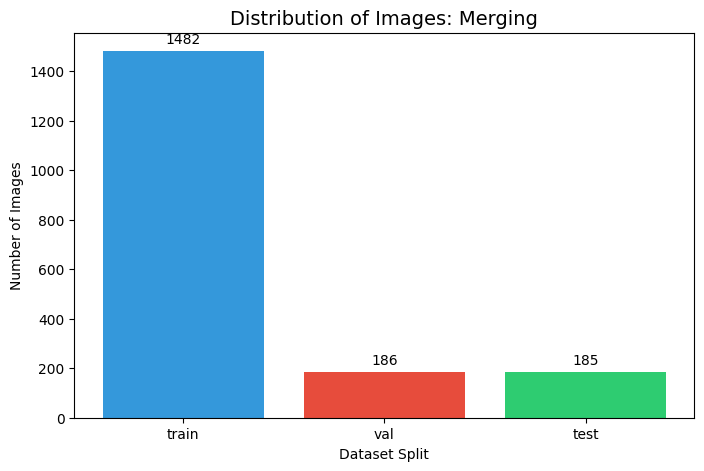

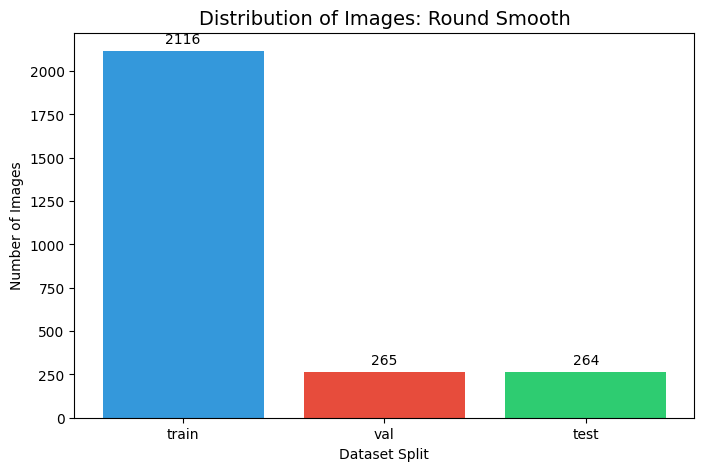

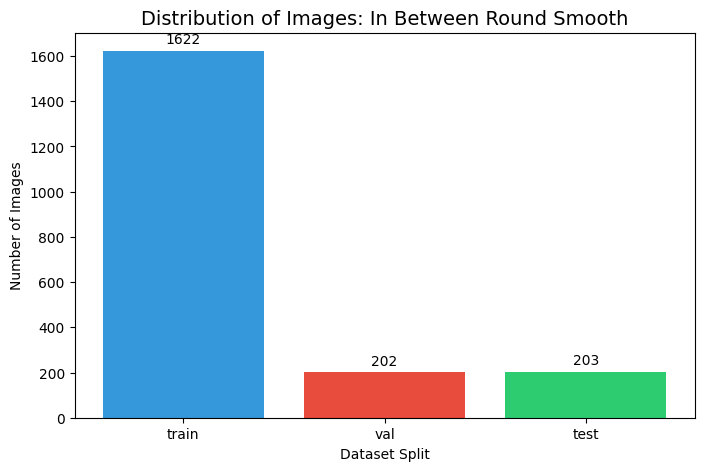

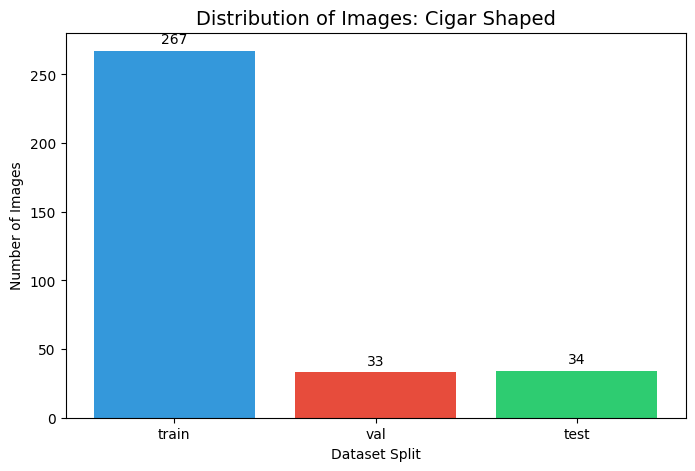

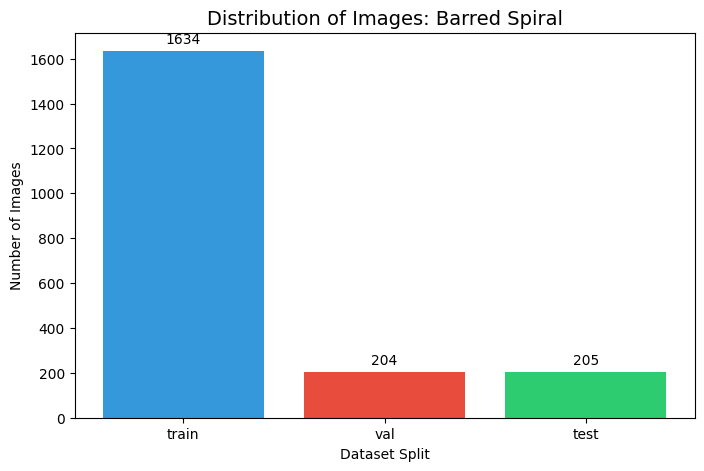

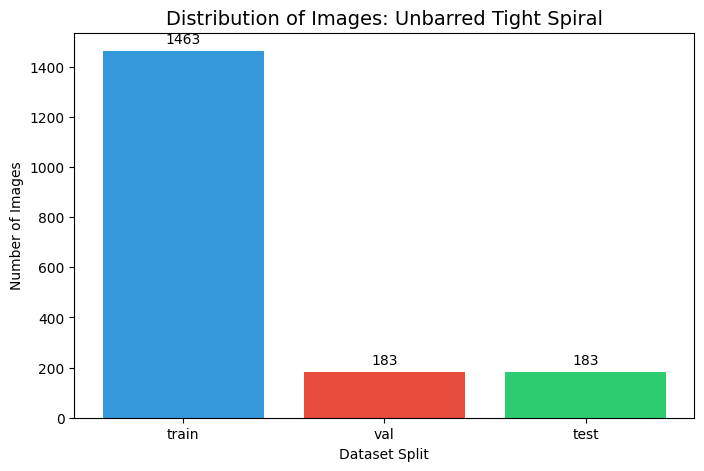

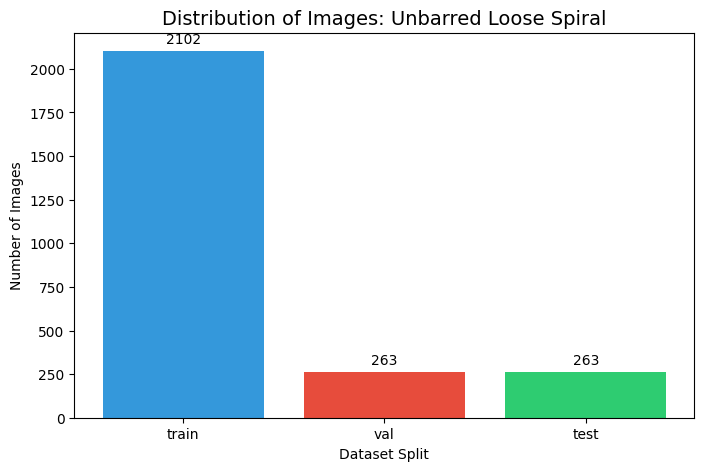

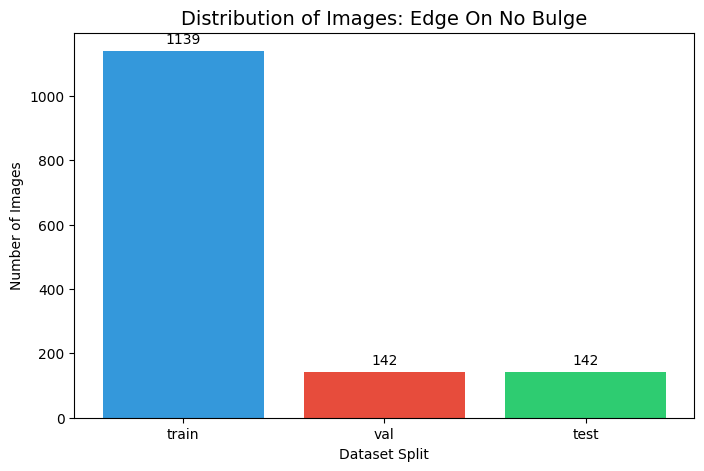

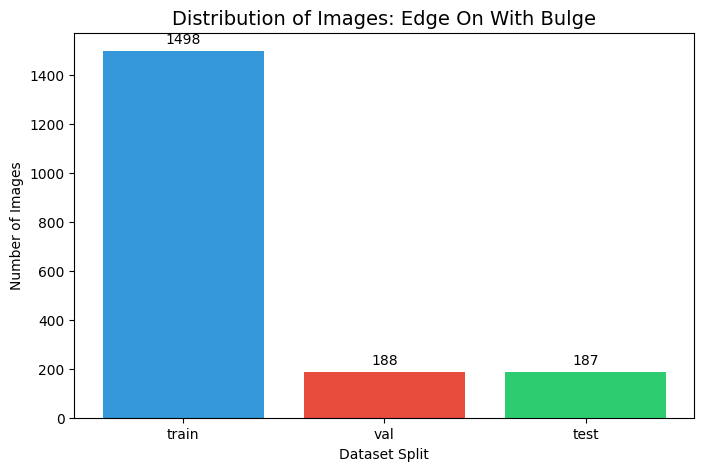

In [4]:
from src.utils.visualisations import train_test_val_graph

for cls_name in CLASS_NAMES:
    train_test_val_graph(cls_name)

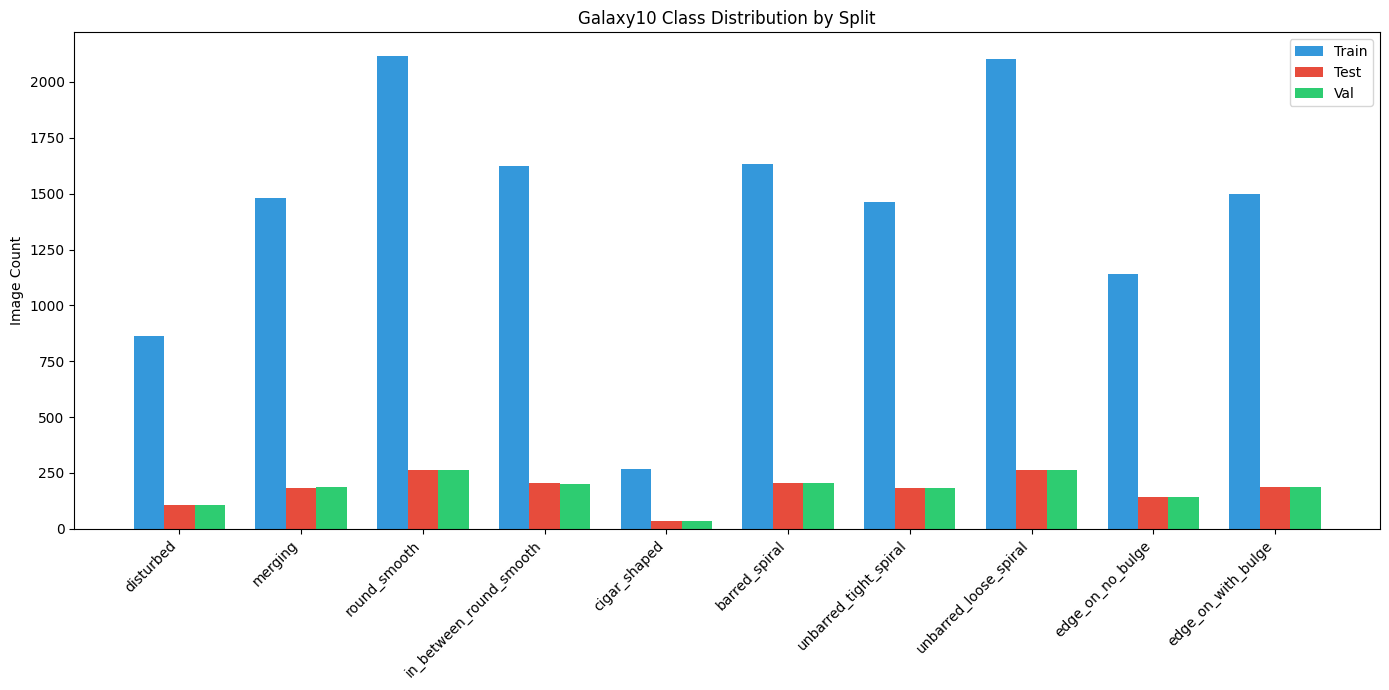

In [ ]:
dataset_dir = Path("../data/Galaxy10_DECaLS")
splits = ["train", "test", "val"]
class_distribution = {}

for galaxy_class in CLASS_NAMES:
    split_count =[0,0,0] #train,test,val
    for i,split in enumerate(splits):
        class_dir = dataset_dir / split / galaxy_class
        img_count = len(list(class_dir.glob("*.jpg")))
        split_count[i] = img_count
    class_distribution[galaxy_class] = split_count


classes = list(class_distribution.keys())
train_data = [counts[0] for counts in class_distribution.values()]
test_data = [counts[1] for counts in class_distribution.values()]
val_data = [counts[2] for counts in class_distribution.values()]

x = np.arange(len(classes))  
width = 0.25  
fig, ax = plt.subplots(figsize=(14, 7))

ax.bar(x - width, train_data, width, label='Train', color='#3498db')
ax.bar(x, test_data, width, label='Test', color='#e74c3c')
ax.bar(x + width, val_data, width, label='Val', color='#2ecc71')

ax.set_ylabel('Image Count')
ax.set_title('Galaxy10 Class Distribution by Split')
ax.set_xticks(x)
ax.set_xticklabels(classes, rotation=45, ha='right')
ax.legend()

plt.tight_layout()
plt.show()

## Creating a Balanced Dataset

The class with the lowest number of samples in the dataset is `cigar_shaped`. To ensure a balanced and fair comparison across all galaxy morphology classes, we construct a reduced dataset by limiting every class to the same number of samples as `cigar_shaped`.

After balancing the dataset, it is split into training and validation sets using an 80:20 ratio. This split ensures that the model has sufficient data to learn meaningful morphological features while still retaining a representative validation set for unbiased performance evaluation.

The split is performed in a stratified manner to preserve class balance across both subsets, which is especially important for multi class galaxy morphology classification tasks.


In [8]:
import random

# Paths
original_root = Path("../data/Galaxy10_DECaLS")
balanced_root = Path("../data/Galaxy10_DECaLS_Balanced")

train_dir = original_root / "train"
val_dir = original_root / "val"
test_dir = original_root / "test"

# Create balanced dataset directories
(balanced_root / "train").mkdir(parents=True, exist_ok=True)
(balanced_root / "test").mkdir(parents=True, exist_ok=True)

print(f"[INFO] Balanced dataset root ready at {balanced_root}")

# Determine base count from round_smooth
round_train = list((train_dir / "cigar_shaped").glob("*.jpg"))
round_val = list((val_dir / "cigar_shaped").glob("*.jpg"))
round_test = list((test_dir / "cigar_shaped").glob("*.jpg"))

round_total = round_train + round_val + round_test

random.shuffle(round_total)

test_size = int(0.2 * len(round_total))
round_test_balanced = round_total[:test_size]
round_train_balanced = round_total[test_size:]

BASE_TRAIN_COUNT = len(round_train_balanced)
BASE_TEST_COUNT = len(round_test_balanced)

# Copy cigar_shaped
for split, images in zip(
    ["train", "test"],
    [round_train_balanced, round_test_balanced]
):
    dst_class_dir = balanced_root / split / "cigar_shaped"
    dst_class_dir.mkdir(parents=True, exist_ok=True)

    for img in images:
        shutil.copy2(img, dst_class_dir / img.name)

# Process remaining classes
for class_name in CLASS_NAMES:
    if class_name == "cigar_shaped":
        continue

    class_train_imgs = list((train_dir / class_name).glob("*.jpg"))
    class_test_imgs = list((test_dir / class_name).glob("*.jpg"))

    random.shuffle(class_train_imgs)
    random.shuffle(class_test_imgs)

    class_train_imgs = class_train_imgs[:BASE_TRAIN_COUNT]
    class_test_imgs = class_test_imgs[:BASE_TEST_COUNT]

    # Copy train images
    train_dst = balanced_root / "train" / class_name
    train_dst.mkdir(parents=True, exist_ok=True)

    for img in class_train_imgs:
        shutil.copy2(img, train_dst / img.name)

    # Copy test images
    test_dst = balanced_root / "test" / class_name
    test_dst.mkdir(parents=True, exist_ok=True)

    for img in class_test_imgs:
        shutil.copy2(img, test_dst / img.name)

print("[INFO] Balanced train and test datasets created successfully.")


[INFO] Balanced dataset root ready at ../data/Galaxy10_DECaLS_Balanced
[INFO] Balanced train and test datasets created successfully.


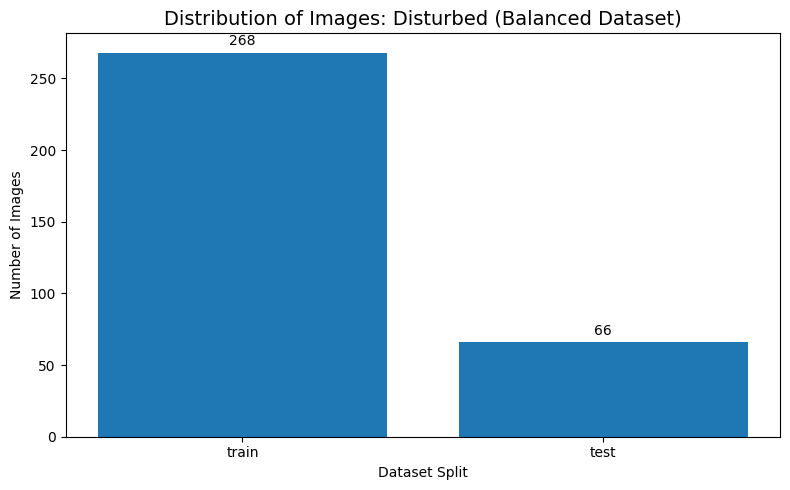

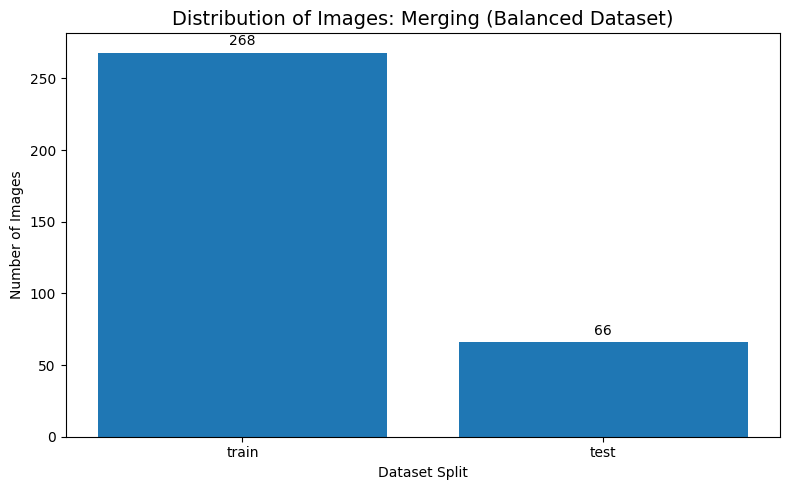

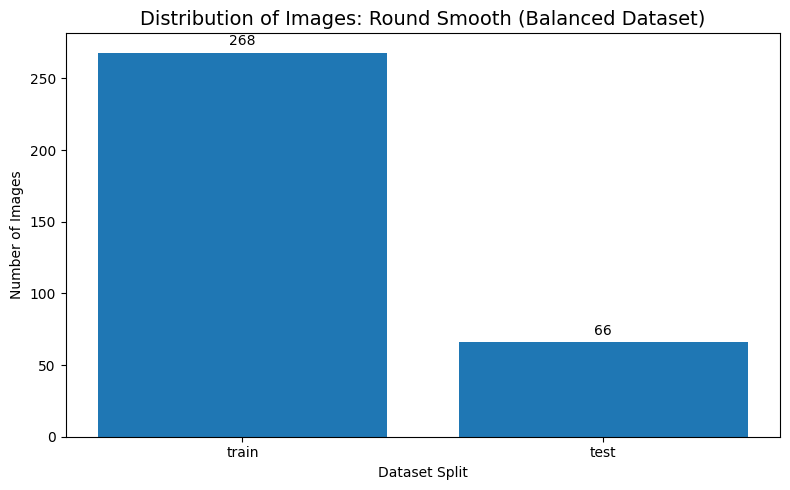

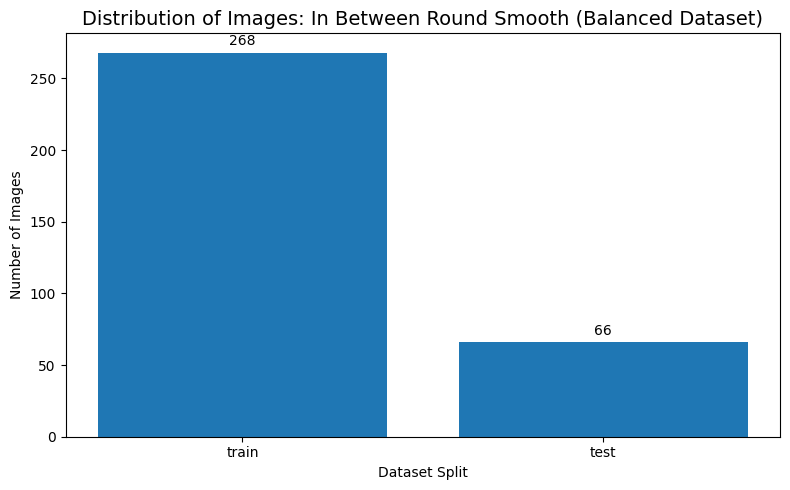

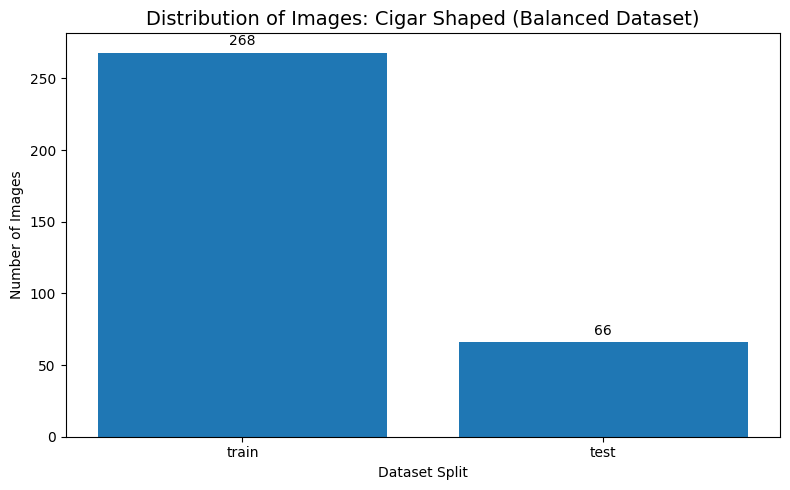

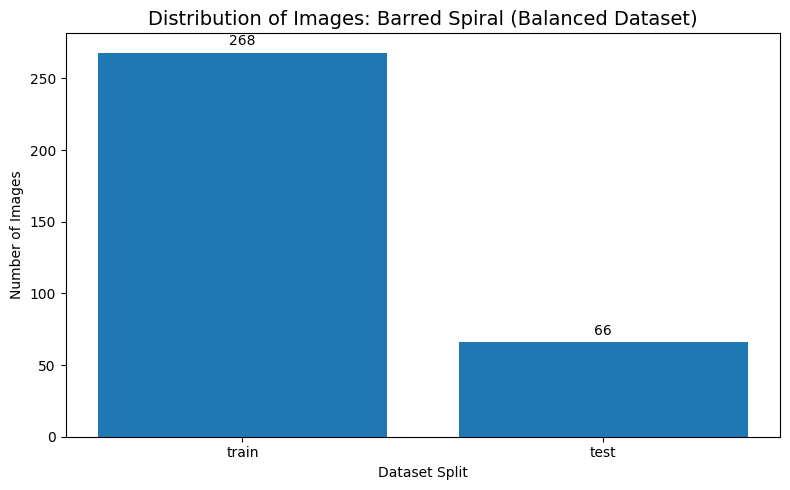

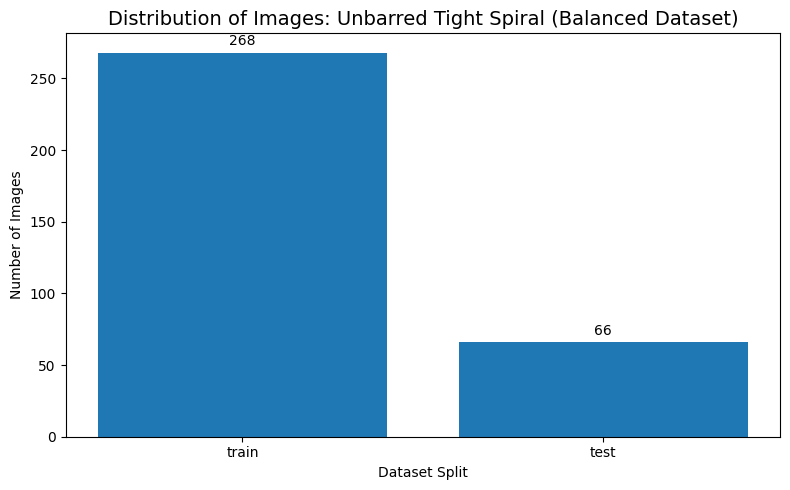

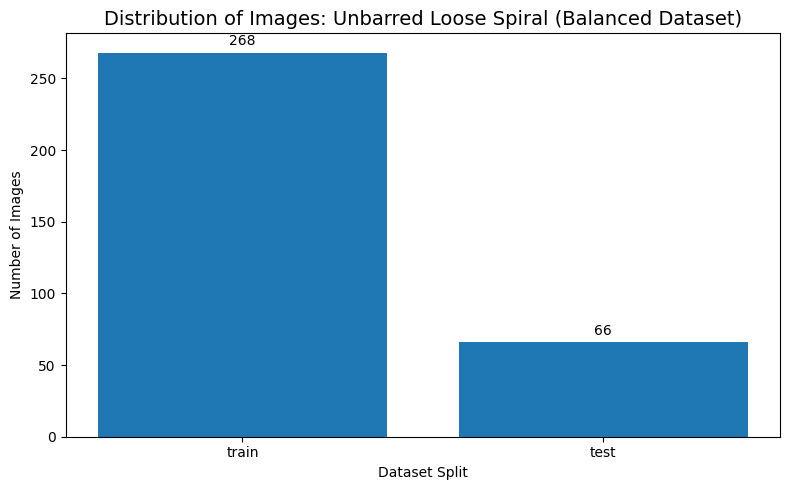

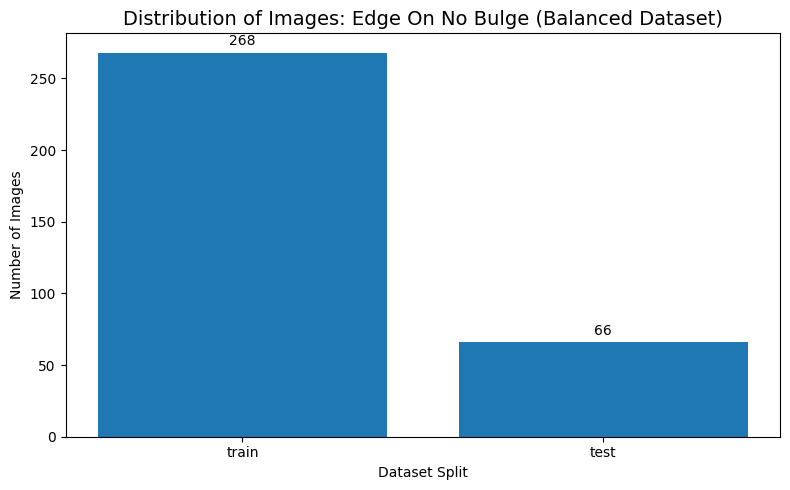

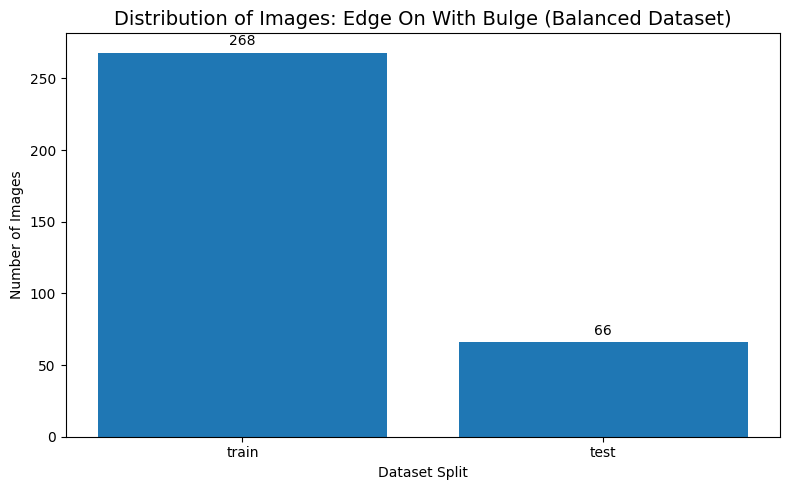

In [9]:
from src.utils.visualisations import train_test_val_graph

for cls_name in CLASS_NAMES:
    train_test_val_graph(cls_name,balanced=True)

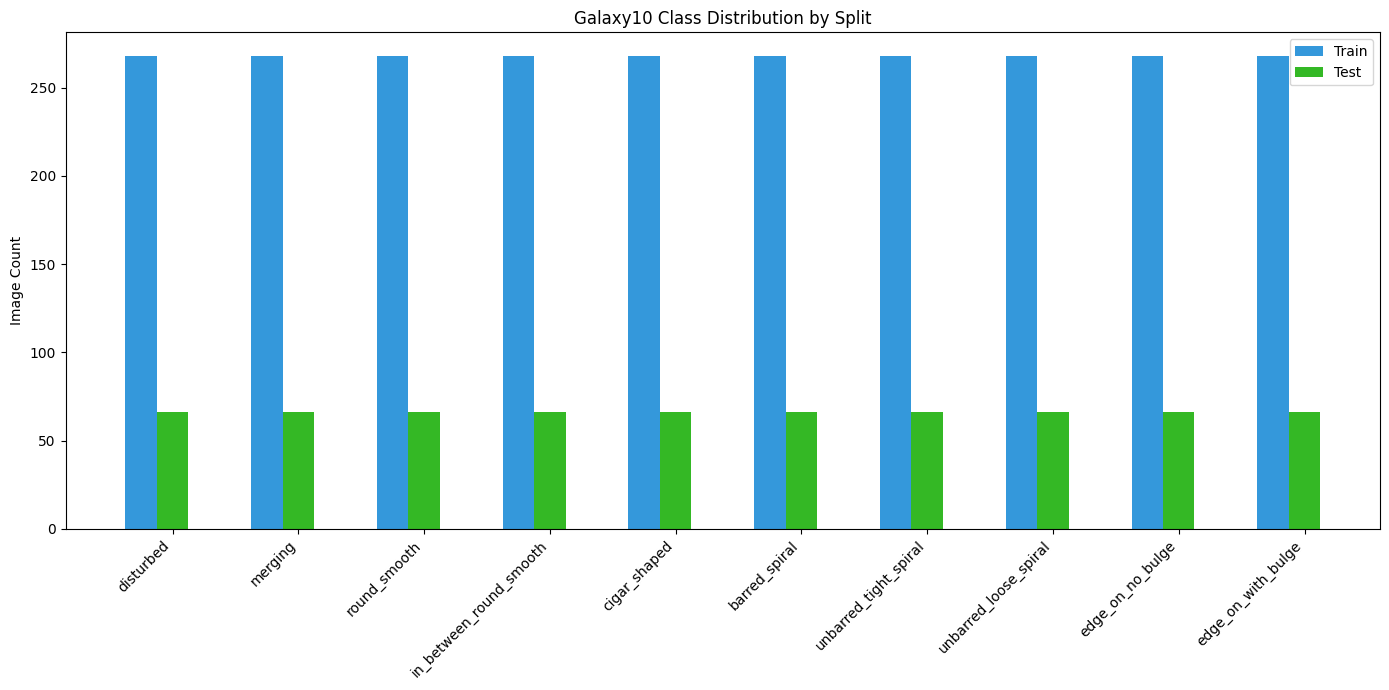

In [10]:
dataset_dir = Path("../data/Galaxy10_DECaLS_Balanced")
splits = ["train", "test"]
class_distribution = {}

for galaxy_class in CLASS_NAMES:
    split_count =[0,0] #train,test
    for i,split in enumerate(splits):
        class_dir = dataset_dir / split / galaxy_class
        img_count = len(list(class_dir.glob("*.jpg")))
        split_count[i] = img_count
    class_distribution[galaxy_class] = split_count


classes = list(class_distribution.keys())
train_data = [counts[0] for counts in class_distribution.values()]
test_data = [counts[1] for counts in class_distribution.values()]

x = np.arange(len(classes))  
width = 0.25  
fig, ax = plt.subplots(figsize=(14, 7))

ax.bar(x - width, train_data, width, label='Train', color='#3498db')
ax.bar(x, test_data, width, label='Test', color="#34b825")

ax.set_ylabel('Image Count')
ax.set_title('Galaxy10 Class Distribution by Split')
ax.set_xticks(x)
ax.set_xticklabels(classes, rotation=45, ha='right')
ax.legend()

plt.tight_layout()
plt.show()